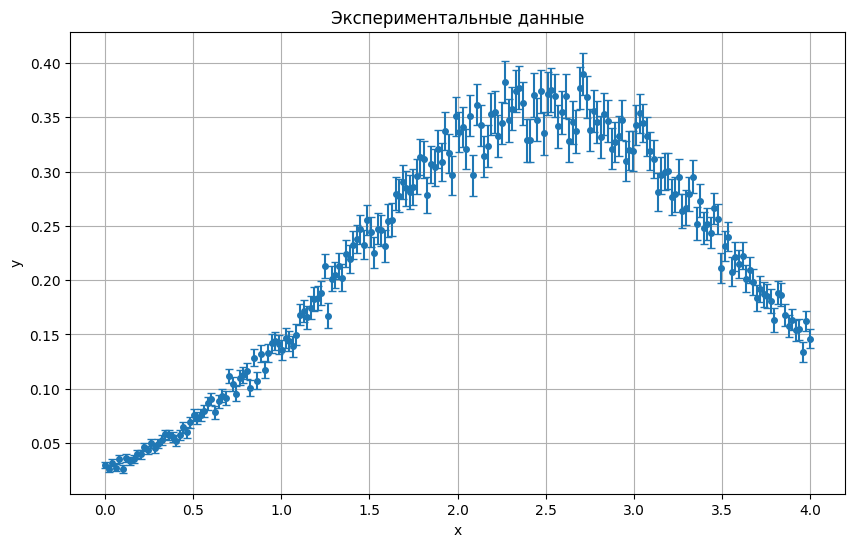

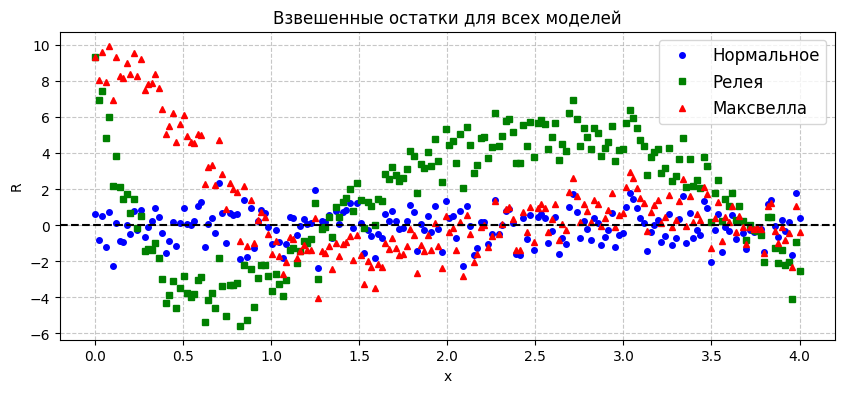

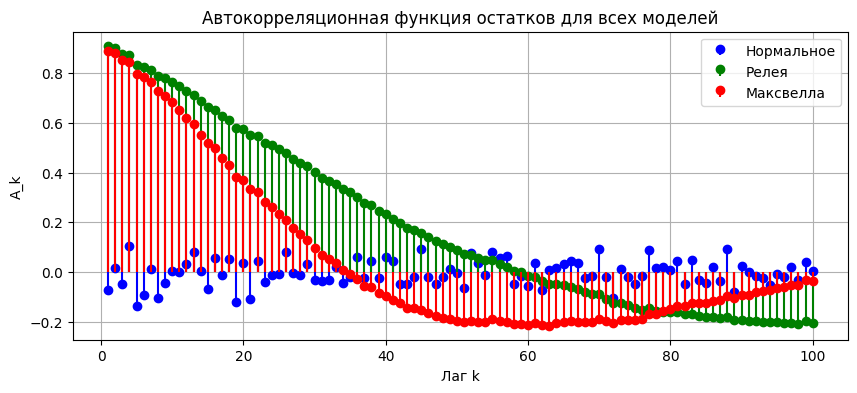

Нормальное распределение: χ²/ν = 0.86
Распределение Релея: χ²/ν = 13.34
Распределение Максвелла: χ²/ν = 10.59


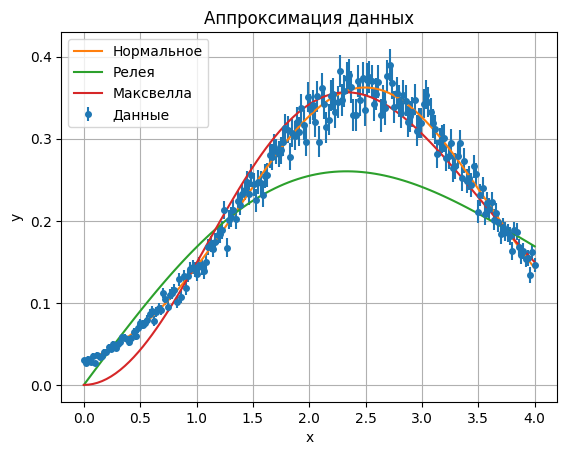


Доверительные интервалы для параметров (68%):
Нормальное распределение:
m: [2.488, 2.500]
s: [1.096, 1.106]

Распределение Релея:
σ: [2.322, 2.338]

Распределение Максвелла:
a: [0.606, 0.609]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

data = np.loadtxt('./Data_Lab2/data2.txt')
x = data[:, 0]
y = data[:, 1]
sigma = data[:, 2]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=sigma, fmt='o', markersize=4, capsize=3)
plt.title('Экспериментальные данные')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

def normal_model(x, m, s):
    return (1/(s*np.sqrt(2*np.pi))) * np.exp(-(x - m)**2/(2*s**2))

def rayleigh_model(x, sigma):
    return (x / sigma**2) * np.exp(-x**2/(2*sigma**2))

def maxwell_model(x, a):
    return np.sqrt(2/np.pi) * a**3 * x**2 * np.exp(-a**2 * x**2 / 2)

theta0_normal = [np.mean(y), np.std(y)] 
theta0_rayleigh = [np.sqrt(np.mean(x**2)/2)]
theta0_maxwell = [np.sqrt(3/np.mean(x**2))]

# parameters optimal (оптимальные параметры модели);
# parameters covariation (ковариационная матрица параметров)
popt_normal, pcov_normal = curve_fit(normal_model, x, y, p0=theta0_normal, 
                                    sigma=sigma, absolute_sigma=True)
popt_rayleigh, pcov_rayleigh = curve_fit(rayleigh_model, x, y, p0=theta0_rayleigh,
                                       sigma=sigma, absolute_sigma=True)
popt_maxwell, pcov_maxwell = curve_fit(maxwell_model, x, y, p0=theta0_maxwell,
                                      sigma=sigma, absolute_sigma=True)

def calculate_chi2(y_true, y_pred, sigma, n_params):
    chi2 = np.sum(((y_true - y_pred)/sigma)**2)
    nu = len(y_true) - n_params - 1
    return chi2, chi2/nu

y_pred_normal = normal_model(x, *popt_normal)
chi2_normal, chi2_nu_normal = calculate_chi2(y, y_pred_normal, sigma, 2)

y_pred_rayleigh = rayleigh_model(x, *popt_rayleigh)
chi2_rayleigh, chi2_nu_rayleigh = calculate_chi2(y, y_pred_rayleigh, sigma, 1)

y_pred_maxwell = maxwell_model(x, *popt_maxwell)
chi2_maxwell, chi2_nu_maxwell = calculate_chi2(y, y_pred_maxwell, sigma, 1)

residuals_normal = (y - y_pred_normal)/sigma
residuals_rayleigh = (y- y_pred_rayleigh)/sigma
residuals_maxwell = (y - y_pred_maxwell)/sigma

plt.figure(figsize=(10, 4))

plt.plot(x, residuals_normal, 'o', markersize=4, label='Нормальное', color='blue')

plt.plot(x, residuals_rayleigh, 's', markersize=4, label='Релея', color='green')

plt.plot(x, residuals_maxwell, '^', markersize=4, label='Максвелла', color='red')

plt.axhline(0, color='black', linestyle='--')

plt.title('Взвешенные остатки для всех моделей')
plt.xlabel('x')
plt.ylabel('R')
plt.legend(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

def autocorrelation(R, k):
    N = len(R)
    return np.sum(R[:N-k] * R[k:]) / np.sum(R**2)

max_lag = len(x) // 2
lags = np.arange(1, max_lag + 1)

autocorr_normal = [autocorrelation(residuals_normal, k) for k in lags]
autocorr_rayleigh = [autocorrelation(residuals_rayleigh, k) for k in lags]
autocorr_maxwell = [autocorrelation(residuals_maxwell, k) for k in lags]

plt.figure(figsize=(10, 4))
plt.stem(lags, autocorr_normal, linefmt='b-', markerfmt='bo', basefmt=' ', label='Нормальное')
plt.stem(lags, autocorr_rayleigh, linefmt='g-', markerfmt='go', basefmt=' ', label='Релея')
plt.stem(lags, autocorr_maxwell, linefmt='r-', markerfmt='ro', basefmt=' ', label='Максвелла')

# Настройки графика
plt.title('Автокорреляционная функция остатков для всех моделей')
plt.xlabel('Лаг k')
plt.ylabel('A_k')
plt.legend()  # Добавляем легенду
plt.grid(True)
plt.show()


def confidence_intervals(popt, pcov, alpha, nu):
    per = t.ppf(1 - alpha/2, nu)
    sigma_params = np.sqrt(np.diag(pcov))
    return np.array([popt - per * sigma_params, popt + per * sigma_params]).T

alpha = 0.32 

nu_normal = len(x) - 2 - 1  # Число степеней свободы
ci_normal = confidence_intervals(popt_normal, pcov_normal, alpha, nu_normal)

nu_rayleigh = len(x) - 1 - 1  # Число степеней свободы
ci_rayleigh = confidence_intervals(popt_rayleigh, pcov_rayleigh, alpha, nu_rayleigh)

nu_maxwell = len(x) - 1 - 1  # Число степеней свободы
ci_maxwell = confidence_intervals(popt_maxwell, pcov_maxwell, alpha, nu_maxwell)

print(f"Нормальное распределение: χ²/ν = {chi2_nu_normal:.2f}")
print(f"Распределение Релея: χ²/ν = {chi2_nu_rayleigh:.2f}")
print(f"Распределение Максвелла: χ²/ν = {chi2_nu_maxwell:.2f}")

best_model = min([(chi2_nu_normal, 'Normal', popt_normal),
                 (chi2_nu_rayleigh, 'Rayleigh', popt_rayleigh),
                 (chi2_nu_maxwell, 'Maxwell', popt_maxwell)], key=lambda x: abs(x[0]-1))

plt.errorbar(x, y, yerr=sigma, fmt='o', markersize=4, label='Данные')
x_fit = np.linspace(x.min(), x.max(), 100)

plt.plot(x_fit, normal_model(x_fit, *popt_normal), label='Нормальное')

plt.plot(x_fit, rayleigh_model(x_fit, *popt_rayleigh), label='Релея')

plt.plot(x_fit, maxwell_model(x_fit, *popt_maxwell), label='Максвелла')

plt.title('Аппроксимация данных')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


print("\nДоверительные интервалы для параметров (68%):")

print("Нормальное распределение:")
print(f"m: [{ci_normal[0][0]:.3f}, {ci_normal[0][1]:.3f}]")
print(f"s: [{ci_normal[1][0]:.3f}, {ci_normal[1][1]:.3f}]")

print("\nРаспределение Релея:")
print(f"σ: [{ci_rayleigh[0][0]:.3f}, {ci_rayleigh[0][1]:.3f}]")

print("\nРаспределение Максвелла:")
print(f"a: [{ci_maxwell[0][0]:.3f}, {ci_maxwell[0][1]:.3f}]")